# **Machine Learning Lesson 1: Building a risk prediction tool for electronic health record data**
* Code adapted from University of Florida course *Biomedical Data Science*, College of Engineering (Parisa Rashidi 2021)

At the end of this lesson, you will be able to:

* Get familar with steps of developing an Artificial intelligence (AI) model
* Execute visualization code for a real-world AI model in electronic health record (EHR) dataset
* Interpret the result of AI model

In this notebook, we will implement two classifiers to predict the risk of a given surgical patient to develop postoperative Acute Kidney Injury (AKI) from a structured dataset of medical predictors. 

## 1. Motivation

Predicting postoperative complications has the potential to inform shared decisions regarding the appropriateness of surgical procedures, targeted risk-reduction strategies, and postoperative resource use. Cognitive and judgment errors are major sources of potentially preventable complications. For example, underestimation of the risk of complications may be associated with postoperative undertriage of high-risk patients to general wards rather than intensive care units (ICUs) and an increased prevalence of hospital mortality.

High-performance data-based clinical decision support has the potential to mitigate harm from cognitive errors occurring when estimating the risk of postoperative complications. All patients have a unique risk profile that is specific to their demographic characteristics, comorbid conditions, physiological reserve, planned surgical procedure, and surgeon’s skill; clinicians have had mediocre performance in estimating risk probabilities. Decision support tools are intended to augment these
estimations, but many are hindered by time-consuming manual data entry requirements and lack of integration with clinical workflow. AI predictive models using automated EHR data inputs may be able to mitigate these challenges.

In this notebook, we will focus on postoperative AKI complication and develop machine learning (ML) models to predict the risk.

## 2. Lifecycle of ML

Following are the major steps that are involved in the ML lifecycle.
<img src="ML.png" alt="ML lifecycle" width="800" height="800">

### Data extraction and processing

Relevant data must be extracted. For example, all revelant laboratory values and vital signs. Data quality and conformation to modeling requirements must be ensured through data preprocessing. For example, fixing the missing data, removing the unwanted outlier, and encoding the categorical data.

### Model development

Using various ML algorithms, we will develop a model on a training cohort. During the model refinement stage, model parameters (such as weights and biases) are altered to optimize the associations between inputs and outputs. 

### Evaluation and Intepretation

Once a ML model is trained, we evaluate the end result on validation dataset to see how well the model performed or how reliable it is. Multiple performance metrics such as sensitivity, specificity will be evaluated. Model explainability or interpretability can be explored at this stage to elucidate the relative importance of inputs. For example, lower eGFR and higher systolic blood pressure associated with outcome.

### Deployment

ML model deployment is the process of placing a finished ML model into the live environment, such as creating a web service or mobile application for prediction. It is imperative that the performance of an established model is continually monitored in prospective deployment to safeguard against population drifts or data shifts that may result in deteriorating performance over time.

### Optimization

When new data sources are coming in or necessary steps for upgrading the performance of the ML model should be taken, we need to optimize the model by reinstructing the ML model in production.

In this notebook, we will only focus on the first three phases. 

## 3. Load and explore dataset 

For this projetc, we will be using the EHR dataset which contains 10,000 surgical patients.

* Each patient profile will contain the demographic variables (age, sex, race etc.), scheduled surgery related variables (doctor, scheduled room, scheduld anesthesia type), admission characteristic variables (emergent, transfer from other hospital etc.), neighborhood charactersitic variables (zip, rural, distance_from_shands etc.), comorbidity variables (diabetes, cancer, hypertension etc.), medications taken within one year before scheduled surgery (aspirin, diuretics, statins etc.), and laboratory measurements taken within 7 days or 8 to 365 days before scheduled surgery (hemoglobin, white blood cell count etc.)
* The outcome is postoperative AKI. In other words the model will predict 'yes' or 'no' for each of surgical patient.

The dataset includes a CSV file that provides the medical predictors and labels for each patient. We start with loading dataset into a Pandas dataframe. 

In [41]:
import pandas as pd
import numpy as np
df = pd.read_csv('data.csv')

df.head()

,patient_id,sex,ethnicity,race,language,marital_status,smoking_status,county,attend_doc,sched_room,...,serum_ca_min_0_7,serum_ca_max_0_7,serum_ca_avg_0_7,serum_ca_var_0_7,count_serum_can_0_7,serum_anion_gap_avg_0_7,count_serum_anion_gapn_0_7,ckd,egfr,aki_surg_disch
0,0,FEMALE,NON-HISPANIC,AA,ENGLISH,DIVORCED,NEVER,Duval,888339,NT OR 09,...,missing,missing,missing,missing,0.0,missing,0.0,No CKD,No eGFR,0.0
1,1,MALE,NON-HISPANIC,WHITE,ENGLISH,MARRIED,CURRENT,Polk,737072,NT OR 12,...,8.6,10.0,9.3,0.6533333333333339,4.0,9.0,2.0,No CKD,95.5001555676506,0.0
2,2,FEMALE,NON-HISPANIC,WHITE,ENGLISH,MARRIED,NEVER,Alachua,984724,HVN OR 14,...,10.0,10.0,10.0,0.0,2.0,7.0,1.0,No CKD,No eGFR,0.0
3,3,MALE,NON-HISPANIC,WHITE,ENGLISH,MARRIED,FORMER,Alachua,322319,ST OR 14,...,8.7,10.3,9.233333333333333,0.2824242424242431,12.0,8.5,6.0,No CKD,89.14911769245806,1.0
4,4,MALE,NON-HISPANIC,WHITE,ENGLISH,SINGLE,NEVER,Union,85055,NT OR 05,...,8.7,9.6,9.025,0.1392857142857141,8.0,12.6,5.0,No CKD,120.95438867365282,0.0


Let us look at the outcome and check the prevalence of postoperative AKI.

In [42]:
print(df['aki_surg_disch'].value_counts())
prevalence = sum(df['aki_surg_disch'] == 1) / len(df['aki_surg_disch']) 
print('prevalence', prevalence)

0.0    8364
1.0    1636
Name: aki_surg_disch, dtype: int64
prevalence 0.1636


## 4. Data preprocessing

Before training, you will first clean the dataset to ensure it conform the modeling requirement. Several steps might be involved:

* Removing outliers
* Fixing missingess
* Transforming the dataset (encode the categorical variables etc.)
* Feature Scaling

Regarding the outlier removing, one common approach is to remove observations that fall in top and bottom x% of the distribution. In provided dataset, we have removed observations in top/bottom 1% of the distribution.

### 4.1 Fixing missingness

Missing data are common in routinely collected health data and often missingness is informative. For example, laboratory data are often missing for intentional (e.g., the patient does not need certain laboratory tests) or unintentional (e.g., lack of routine checkup or follow-up) reasons. Estimation bias and model performance from missingness can be mitigated using imputation methods.

One simple but effective imputation approach is replacing missing values for each individual value by using a quantitative attribute or qualitative attribute of all the non-missing values. Methods such as replacing missing values with mode, mean or median of the available values are often used. 

Let's look at one variable 'serum_ca_min_0_7' (minimum serum calcium with 0-7 days before scheduled surgery start time). This variable contains missing value marked with 'missing'. Let's impute those missing values with median of the available values. 

In [43]:
print('---before imputation---')
print(df['serum_ca_min_0_7'].head())

---before imputation---
0    missing
1        8.6
2       10.0
3        8.7
4        8.7
Name: serum_ca_min_0_7, dtype: object


We first convert those cells with 'missing' vlaue into empty cells. Then we check the median value. 

In [44]:
##we first remove 'missing' and convert all available values to numeric values. If ‘coerce’, then invalid parsing will be set as NaN
df['serum_ca_min_0_7'] = pd.to_numeric(df['serum_ca_min_0_7'], errors='coerce')
print(df['serum_ca_min_0_7'].head())

##calculate median value
val = df['serum_ca_min_0_7'].median()
print('median value', val)

0     NaN
1     8.6
2    10.0
3     8.7
4     8.7
Name: serum_ca_min_0_7, dtype: float64
median value 9.1


Let's use fillna() function to fill all empty cells with median value. We will add one more column 'imputed_serum_ca_min_0_7' to save the imputed value for comparison.  

In [45]:
df['imputed_serum_ca_min_0_7'] = df['serum_ca_min_0_7'].fillna(val)
print('---after imputation with median value---')
print(df['imputed_serum_ca_min_0_7'].head())

---after imputation with median value---
0     9.1
1     8.6
2    10.0
3     8.7
4     8.7
Name: imputed_serum_ca_min_0_7, dtype: float64


Now the missing value has been replace to median value 9.1. Let's try imputing the missing values with mean function.

In [46]:
###Todo: change 'X' to 'mean' to calculate the mean value
# val = df['serum_ca_min_0_7'].X()
val = df['serum_ca_min_0_7'].mean() # New
print('mean value', val)
df['imputed_serum_ca_min_0_7'] = df['serum_ca_min_0_7'].fillna(val)
print('---after imputation with mean value---')
print(df['imputed_serum_ca_min_0_7'].head())

mean value 9.00409984871407
---after imputation with mean value---
0     9.0041
1     8.6000
2    10.0000
3     8.7000
4     8.7000
Name: imputed_serum_ca_min_0_7, dtype: float64


In addition to this simple imputation, there are also other popular imputation approaches, such as k-Nearest neighbors (KNN) and multiple imputation by chained equation (MICE). For more information, you can refer to [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#examples-using-sklearn-impute-knnimputer) and [MICE](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer).

### 4.2 Transforming the dataset

EHR data contains both categorical values and numeric values. However, most Python models now only accept numeric values. We need to convert all categorical values to numeric values.

Let's look at one variable 'sex' which contains two levels: 'FEMALE' and 'MALE'. For these binary values, we can transform these values to numeric values by simply replacing them with 0 and 1 respectively.

In [47]:
print('---before tranformation---')
print(df['sex'].unique())
##let us replace 'FEMALE' with 0 and 'MALE' with 1
df['sex'] = df['sex'].replace({'FEMALE' : 0, 'MALE' : 1})
print('---after tranformation---')
print(df['sex'].unique())

---before tranformation---
['FEMALE' 'MALE']
---after tranformation---
[0 1]


Let's try another variable 'anesthesia_type' which contains two levels: 'GENERAL'and 'LOCAL/REGIONAL'.

In [48]:
print('---before tranformation---')
print(df['anesthesia_type'].unique())
##Todo: let us replace 'X' and 'Y' with two 'anesthesia_type' levels 'GENERAL'and 'LOCAL/REGIONAL' respectively
# df['anesthesia_type'] = df['anesthesia_type'].replace({X : 0, Y : 1})
df['anesthesia_type'] = df['anesthesia_type'].replace({'GENERAL' : 0, 'LOCAL/REGIONAL' : 1}) #New
print('---after tranformation---')
print(df['anesthesia_type'].unique())

---before tranformation---
['GENERAL' 'LOCAL/REGIONAL']
---after tranformation---
[0 1]


If the categorical values contains two more levels and the variable does not follow some natural order, such as 'marital_status', we cannot simlply use 0,1,2 to replace each level. One common way to process is that for each level of a variable, we make it as extra feature and consider the presence and absence of that feature. Let's see the example.

In [49]:
print('---before transformation---')
print(df['marital_status'].head())
marital_status_transformed = pd.get_dummies(df['marital_status'])
print('---after transformation---')
print(marital_status_transformed.head())

---before transformation---
0    DIVORCED
1     MARRIED
2     MARRIED
3     MARRIED
4      SINGLE
Name: marital_status, dtype: object
---after transformation---
   DIVORCED  MARRIED  MISSING  SINGLE
0         1        0        0       0
1         0        1        0       0
2         0        1        0       0
3         0        1        0       0
4         0        0        0       1


We have briefly introduced the phase 'data extraction and processing' and are going to the develop ML models for our prediction task. To simplify our project, a processed data file has been provided. Let's load it.  

In [50]:
df = pd.read_csv('processed_data.csv')
print(df.head())

   patient_id  sex  ethnicity      race  language  marital_status  \
0           0    0  -1.796259 -1.657746         1       -1.605578   
1           1    1  -1.796259 -1.827618         1       -1.801145   
2           2    0  -1.796259 -1.827618         1       -1.801145   
3           3    1  -1.796259 -1.827618         1       -1.801145   
4           4    1  -1.796259 -1.827618         1       -1.924585   

   smoking_status    county  attend_doc  sched_room  ...  serum_ca_min_0_7  \
0       -2.021878 -1.467852   -2.074528   -2.480968  ...               9.1   
1       -1.771219 -1.860752   -2.464866   -2.700371  ...               8.6   
2       -2.021878 -2.078109   -2.546061   -2.055911  ...              10.0   
3       -1.686798 -2.078109   -1.334699   -1.326118  ...               8.7   
4       -2.021878 -1.847705   -1.945910   -2.324189  ...               8.7   

   serum_ca_max_0_7  serum_ca_avg_0_7  serum_ca_var_0_7  count_serum_can_0_7  \
0               9.4          9.21250

### 4.3 Feature Scaling

The dataset often contains different types of variables and the range of the variables may differ a lot. Let's check two variables in our dataset, such as 'serum_creatinine_min_0_7' and 'serum_anion_gap_avg_0_7'.

In [51]:
print(df['serum_creatinine_avg_0_7'].describe())
print(df['serum_anion_gap_avg_0_7'].describe())

count    10000.000000
mean         0.946957
std          0.402052
min          0.200000
25%          0.800000
50%          0.885000
75%          0.980000
max          9.050000
Name: serum_creatinine_avg_0_7, dtype: float64
count    10000.000000
mean        10.801996
std          2.453134
min          2.000000
25%          9.000000
50%         11.000000
75%         12.333333
max         24.000000
Name: serum_anion_gap_avg_0_7, dtype: float64


Using the original scale, the model may put more weight on the variables with a large scale. Thus the performance of model might go down. In order to deal with this problem, we need to apply the technique of feature scaling to make sure features are on almost the same scale.

Notice that not all ML models require feature scaling. ML algorithms like linear regression, logistic regression, neural network, PCA (principal component analysis), etc., require data to be scaled. Tree based ML algorithms like random forest, decision tree, extreme gradient boosting often don't require feature scaling.  

Two frequently used feature scaling approaches are **Z-score normalization** and **Min-Max normalization**. Applying Z-score normalization will rescale the variable to have a **mean of zero** and a **standard deviation of one**. The Min-Max scaling will rescale the variable to a **fixed range, usually 0-1**. 


We will be using some data processing functions from the library scikit-learn.

* Scikit-learn is an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection, model evaluation, and many other utilities. (https://scikit-learn.org/stable/getting_started.html)


In [52]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
##split dataset into features (X) and labels (Y)
X = df[df.columns.tolist()[1:-1]].values
Y = df['aki_surg_disch'].values

##z-score normalization on features
#init the scaler
scaler = StandardScaler()
#fit the scaler to the data
scaler.fit(X)
X_normalized = scaler.transform(X)

#check the mean and standard deviation of all variables, should be 0 and 1 respectively
print('mean', np.mean(X_normalized, axis=0))
print('standard deviation', np.std(X_normalized, axis=0))

mean [-2.80664381e-17 -6.68265443e-16  7.21058768e-15 -1.30739863e-16
 -2.07620587e-15 -6.06448225e-16  1.50492951e-15 -5.75539616e-17
 -2.33058017e-16 -1.27897692e-17  3.99502653e-16  9.23705556e-18
  7.10542736e-17  7.81597009e-18  1.02318154e-16  4.81037432e-16
 -5.22959454e-15  2.34479103e-17  1.07647224e-16 -2.28439490e-16
 -6.75015599e-17 -5.68434189e-17 -2.94875235e-17  5.71986902e-16
 -1.70530257e-17  2.95656832e-15  2.55795385e-17 -1.20081722e-16
 -1.92557081e-16 -8.73967565e-17  1.00897068e-16 -2.13162821e-17
  1.13686838e-17  1.08002496e-16 -1.70530257e-17  8.10018719e-17
  7.81597009e-18 -2.06057393e-17  3.55271368e-17  6.39488462e-18
  6.60804744e-17 -2.13162821e-18 -7.38964445e-17 -7.81597009e-18
  3.87245791e-17  4.76063633e-17 -1.27897692e-17 -8.17124146e-18
  3.41060513e-17 -1.42108547e-18 -2.77111667e-17  2.34479103e-17
  4.47641924e-17 -4.76063633e-17  7.46069873e-18  3.12638804e-17
  3.90798505e-17 -6.65245636e-17 -6.35935749e-17 -2.34479103e-17
  2.48689958e-18  4.

Now let's play with Min-Max normalization.

In [53]:
##min-max normalization on features
#init the scaler
scaler = MinMaxScaler()
#fit the scaler to the data
scaler.fit(X)
X_minmax_normalized = scaler.transform(X)

#check the min and max value of all variables, should be 0 and 1 respectively. 
print('min value', np.min(X_minmax_normalized, axis=0))
print('max value', np.max(X_minmax_normalized, axis=0))

min value [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
max value [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## 5. ML Model development

We will develop two ML models. One is a conventional but effective machine learning model, extreme gradient boosting (XGBoost). Another one is a simple deep learning model, multi-layer perceptron (MLP).

Before digging into the model developing, we will first divide our dataset into a training set (sometimes referred to as a development set), and a testing set (sometimes referred to as a validation set). Split dataset into a training set and a testing set. Here we use a random 20% of samples as our testing set to evaluate model performance. We will also set an (optional) random state for reproducibility.

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, Y, test_size=0.20, random_state=1)
print("Train set shape: ", X_train.shape)
print("Test set shape: ", X_test.shape)

Train set shape:  (8000, 137)
Test set shape:  (2000, 137)


### 5.1 XGBoost model

Let's start developing our XGBoost model. We will train our model using training dataset.

In [55]:
import xgboost as xgb
#Init classifier
xgb_cl = xgb.XGBClassifier()


#Fit the model to training dataset
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

Once the model is trained, we need to evaluate the performance of model on testing dataset. We first need to use our model to predict the outcome and compare the prediction with ground truth.Since our outcome is binary (0/1), for each of 2000 test samples, two values will be generated. For example, (0.7,0.3) means that the patient will have 70% chance not to develop postoperative AKI, and 30% chance to develop postoperative AKI. The class that have larger probability will be selected as the final prediction.

In [56]:
y_prob = xgb_cl.predict_proba(X_test)
print(y_prob.shape)
print(y_prob)

(2000, 2)
[[0.99167347 0.00832656]
 [0.9913942  0.00860579]
 [0.9961532  0.00384684]
 ...
 [0.43677193 0.5632281 ]
 [0.99023664 0.00976333]
 [0.9516187  0.04838132]]


In [57]:
y_hat = np.argmax(y_prob, axis=1)
y_hat

array([0, 0, 0, ..., 1, 0, 0])

Let's evaluate the performance of our model usin
#### Accuracy
It calculates ratio of number of correct predictions to the total number of input samples.

In [58]:
accuracy = sum(y_hat == y_test) / len(y_test)
accuracy

0.8475

### Feature importance

ML model should be explainable to provide some understanding between the input features and the output. XGBoost can automatically provide estimates of feature importance from a trained predictive model. Using attribute name 'feature_importances_' we can get the feature importance score for all input features.

In [59]:
print(xgb_cl.feature_importances_)

[0.00523487 0.00465262 0.00488358 0.00562574 0.00499612 0.00562071
 0.00458559 0.00817062 0.00830173 0.         0.03641732 0.00674455
 0.00655147 0.00908501 0.01049678 0.00487934 0.00511769 0.00988179
 0.01279844 0.00585523 0.00707159 0.00670204 0.00712389 0.00540621
 0.00584235 0.00845196 0.00846781 0.00628176 0.00611165 0.0061715
 0.00601843 0.00321217 0.0049367  0.01053559 0.00737355 0.00231154
 0.         0.00136139 0.00655475 0.004007   0.00410873 0.00402686
 0.00654819 0.00699738 0.00387213 0.01250133 0.00628857 0.00360613
 0.0033693  0.00577783 0.00696724 0.00671653 0.02040027 0.0062748
 0.00595305 0.00536856 0.00997729 0.00599094 0.00805699 0.008273
 0.0054919  0.00626372 0.00586068 0.00581319 0.00620992 0.007451
 0.01131509 0.01362963 0.         0.         0.         0.01440156
 0.00669511 0.00870439 0.00518164 0.01037926 0.00861936 0.00542083
 0.00861842 0.0091252  0.00706168 0.0069644  0.007368   0.00661351
 0.01355573 0.00499858 0.00946412 0.01300297 0.00611423 0.00454162
 

Let's list top 20 features and their scores.

<AxesSubplot:ylabel='feature_name'>

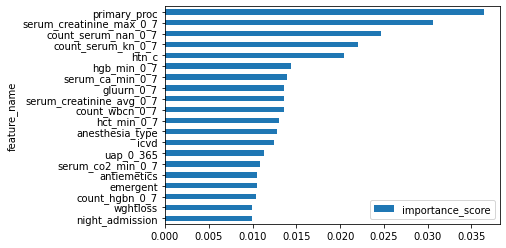

In [60]:
feature_names = df.columns.tolist()[1:-1]
feature_importance_df = pd.DataFrame({'feature_name' : feature_names, 'importance_score' : xgb_cl.feature_importances_})

###sort the feature importance
feature_importance_df = feature_importance_df.sort_values(['importance_score'])
top_20_features = feature_importance_df.tail(20)
top_20_features.plot.barh(x='feature_name', y='importance_score')

We observed that the top 5 features including the scheduled primary procedure code, some laboratory measurements with 0-7 days before surgery start time (i.e., serum creatinine, serum sodium and serum potassium) and hypertension comorbidity contribute most to the model prediction.

### 5.2 MLP model
We will use Keras to create a fully-connected neural network for our prediction task. This type of deep learning architecture is sometimes also known as a multi-layer perceptron (MLP). It is a relatively simple deep learning model that passes input data through multiple hidden layers (each with a number of hidden neurons and a particular activation function) to produce an output (see figure below). We will construct our model to perform a classification task from our dataset.
<img src="ANN.jpg" alt="ANN" width="600" height="600">

There are many ways to create a model using the Keras API. Here, we will create a Sequential object, which is a way to define a series of layers that make up our model. In a Sequential model, input data will flow from one layer to the next, in the order that we define our layers.

In [61]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential

model = Sequential()

Each hidden layer of our neural network will be created using the **Dense** class from Keras. For each layer, we must define the number of hidden units (also known as neurons). There are several optional arguments we may also pass, which can be viewed in the [Keras documentation page](https://keras.io/api/layers/core_layers/dense/). We can add many layers to our deep learning model using the .add() function of the Sequential class. You can think of a Sequential container as a list of hidden layers.

For the first layer of our neural network, we must tell Keras how many variables to expect in each input vector. From our previous data exploration, we know that each patient is defined by 137 different variables, so the input dimension to our network is 137.

One reason why deep learning models are so powerful is their ability to model complex variable interactions through nonlinear activation functions. We have several choices for activation function. In our example, we will use the commonly chosen Rectified Linear Unit activation (ReLU).

In [62]:
model.add(layers.Dense(units=500, input_dim=137, activation='relu'))

So far our model has a single hidden layer. Let's add one more hidden layer with 800 hidden units.

In [63]:
model.add(layers.Dense(units=800, activation='relu'))

Once we are satisfied with the hidden layers of our model, we need to add an output layer for generating class predictions. Our output layer will also be a Dense layer, but it will only have a single (1) unit. Instead of ReLU, we will use a sigmoid activation function, which is typically chosen for binary classification problems such as ours. Using a sigmoid activation on our output layer allows us to interpret the output as a prediction probability. In other words, the probability that a given input vector belongs to class 1.

In [64]:
model.add(layers.Dense(units=1, activation='sigmoid'))

Now that we have defined the architecture of our neural network, we will use the .compile() function to build it. In our example we are defining a few arguments that are associated with the training of our model:
* We are using a binary cross-entropy loss. This is an appropriate choise for binary classification.
* We will be using the Adam optimizer, which is a popular version of stochastic gradient descent (SGD).
* For this example, we are interested in our model's prediction accuracy, so we'll tell Keras to use the "accuracy" metric. 

In [65]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Now it's time to train our prediction model! We will fit the model using our training dataset. We will use the one-line function **.fit()** to train our entire deep learning model.

* We will tell Keras to train the model for 10 epochs.
* We will use a batch size of 64 samples. During each epoch, the model will pass in 64 samples at a time.
* We will use a random 30% of the training dataset as our hold-out dataset (here called the validation set) for computing metrics.

In [66]:
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split= 0.3)

Epoch 1/10
88/88 [==============================] - 11s 78ms/step - loss: 0.3920 - accuracy: 0.8389 - val_loss: 0.3845 - val_accuracy: 0.8338
Epoch 2/10
88/88 [==============================] - 7s 77ms/step - loss: 0.3316 - accuracy: 0.8632 - val_loss: 0.3726 - val_accuracy: 0.8367
Epoch 3/10
88/88 [==============================] - 7s 79ms/step - loss: 0.2896 - accuracy: 0.8855 - val_loss: 0.3760 - val_accuracy: 0.8433
Epoch 4/10
88/88 [==============================] - 6s 71ms/step - loss: 0.2446 - accuracy: 0.9030 - val_loss: 0.3908 - val_accuracy: 0.8342
Epoch 5/10
88/88 [==============================] - 6s 73ms/step - loss: 0.2019 - accuracy: 0.9239 - val_loss: 0.4537 - val_accuracy: 0.8146
Epoch 6/10
88/88 [==============================] - 6s 67ms/step - loss: 0.1620 - accuracy: 0.9366 - val_loss: 0.4860 - val_accuracy: 0.8358
Epoch 7/10
88/88 [==============================] - 6s 67ms/step - loss: 0.1116 - accuracy: 0.9611 - val_loss: 0.5357 - val_accuracy: 0.8163
Epoch 8/10
8

Let's check the performance of our trained model on the test set we already created. The model has never seen this particular data, so it can provide an idea of how well the model might perform in the future (generalizability to unseen data). We will use the Keras function .evaluate(), which will compute the loss, as well as any metrics we defined when compiling our model. Since we told Keras to use "accuracy" when we compiled, we will see the model's accuracy on the test data.

In [67]:
scores = model.evaluate(X_test, y_test)

63/63 [==============================] - 1s 22ms/step - loss: 0.6830 - accuracy: 0.8235


Let's try another neural network! We will have three hidden layers with hidden units 500, 800 and 1000 respectively. 

In [68]:
model = Sequential()
###first hidden layer with 500 hidden units, input layer with 137 variables as input
model.add(layers.Dense(units=500, input_dim=137, activation='relu'))
###second hidden layer with 800 hidden units
model.add(layers.Dense(units=800, activation='relu'))
###Third hidden layer with 1000 hidden units
###To do, add third hidden layer with 1000 hidden units
model.add(layers.Dense(units=1000, activation='relu')) #New
###last output layer
model.add(layers.Dense(units=1, activation='sigmoid'))

##compile and train the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split= 0.3)

Epoch 1/10
88/88 [==============================] - 17s 167ms/step - loss: 0.3956 - accuracy: 0.8366 - val_loss: 0.3791 - val_accuracy: 0.8388
Epoch 2/10
88/88 [==============================] - 12s 139ms/step - loss: 0.3309 - accuracy: 0.8627 - val_loss: 0.4008 - val_accuracy: 0.8367
Epoch 3/10
88/88 [==============================] - 12s 136ms/step - loss: 0.2967 - accuracy: 0.8773 - val_loss: 0.3993 - val_accuracy: 0.8217
Epoch 4/10
88/88 [==============================] - 12s 137ms/step - loss: 0.2431 - accuracy: 0.9038 - val_loss: 0.4352 - val_accuracy: 0.8346
Epoch 5/10
88/88 [==============================] - 14s 154ms/step - loss: 0.1989 - accuracy: 0.9205 - val_loss: 0.5105 - val_accuracy: 0.8021
Epoch 6/10
88/88 [==============================] - 12s 133ms/step - loss: 0.1368 - accuracy: 0.9482 - val_loss: 0.6352 - val_accuracy: 0.8221
Epoch 7/10
88/88 [==============================] - 11s 131ms/step - loss: 0.1104 - accuracy: 0.9623 - val_loss: 0.6337 - val_accuracy: 0.8388

Evaluate the performance of new model.

In [69]:
scores = model.evaluate(X_test, y_test)

63/63 [==============================] - 2s 32ms/step - loss: 0.8217 - accuracy: 0.8325
